In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image

In [2]:
device = 'cuda'

In [47]:
def get_xy(size=224, r=3.0**0.5):
    if type(size) is int:
        size = [size, size]
    if size[0] >= size[1]:
        ratio = size[0] / size[1]
        rng0 = torch.linspace(-r * ratio, r * ratio, size[0])
        rng1 = torch.linspace(-r, r, size[1])
    else:
        ratio = size[1] / size[0]
        rng0 = torch.linspace(-r, r, size[0])
        rng1 = torch.linspace(-r * ratio, r * ratio, size[1])
    xy = torch.stack([*torch.meshgrid(rng0, rng1)], -1).float()
    xy = torch.unsqueeze(xy, 0).permute(0, 3, 1, 2)
    return xy
xy = get_xy().to(device)

In [4]:
def composite_activation(x):
    x = torch.atan(x)
    return torch.cat([x/0.67, (x*x)/0.6], 1)

In [5]:
class CompositeAct(nn.Module):
    def __init__(self):
        super(CompositeAct, self).__init__()
    def forward(self, x):
        return composite_activation(x)

class Net(nn.Module):
    def __init__(self, widths):
        super(Net, self).__init__()
#         act_fn = torch.nn.Hardtanh
#         act_fn = torch.nn.Tanh
        k = 1
        act_fn = CompositeAct
        self.fcs = []
        widths = [2] + widths + [3]
        w0 = widths[0]
        for i, w1 in enumerate(widths[1:]):
            this = nn.Sequential()
#             this.add_module('bn{}'.format(i), nn.BatchNorm2d(w0))
            this.add_module('conv{}'.format(i), nn.Conv2d(w0, w1, k))
            nn.init.normal_(this[-1].weight, std=np.sqrt(1 / (w0 * (k ** 2))))
            if i < len(widths) - 2:
                this.add_module('act{}'.format(i), act_fn())
                w0 = w1 * 2
                pass
            self.fcs.append(this)
        self.fcs = nn.Sequential(*self.fcs)
        self.final_act = nn.Sigmoid()

    def forward(self, x):
        x = self.fcs(x)
#         for fc in self.fcs:
#             x = fc(x)
#             print(x.view(-1).mean(), x.view(-1).std())
        x = self.final_act(x)
        return x
widths = [24] * 4
viz = Net(widths)

viz = viz.to(device)
xy = xy.to(device)

with torch.no_grad():
    res = viz(xy)

In [63]:
def display_tch_im(gend_img, size=None):
    im = gend_img[0].permute(1, 2, 0)
    im = im.detach().cpu().numpy()
    im = (im * 255).astype(np.uint8)
    if size is None:
        size = im.shape[:2]
        if size[0] < 100:
            m = 10
        else:
            m = 1
    else:
        s = size
    display(Image.fromarray(im).resize((size[1] * m, size[0] * m), Image.ANTIALIAS))

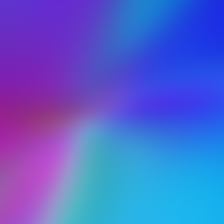

In [52]:
display_tch_im(res)

In [8]:
res.min(), res.max()

(tensor(0.0803, device='cuda:0'), tensor(0.9394, device='cuda:0'))

In [9]:
def render_vis(model, objective, param_f, opt, iters=100, log_interval=10):
    for i in range(iters):
        opt.zero_grad()
        gend_img = param_f()
        cost = objective(gend_img)
        cost.backward()
        if i % log_interval == 0:
            print('weight', viz.fcs[-2][0].weight.mean().item())
            print('grad', torch.abs(viz.fcs[-2][0].weight.grad).mean())
            print('cost', cost.item())
        opt.step()
        if i % log_interval == 0:
            display_tch_im(gend_img)

def get_xor_im(hw):
    xor_im = torch.zeros([1, 3, hw, hw])
    xor_im[:, :, :hw//2, :hw//2] = 1
    xor_im[:, :, hw//2:, hw//2:] = 1
    return xor_im.to(device)
xor_im = get_xor_im(size)

def xor_objective(output):
    return torch.mean((output - xor_im) ** 2)

widths = [24] * 3
viz = Net(widths).to(device)

cppn_f = lambda: viz(xy)
# opt = optim.Adam(viz.parameters(), lr=0.01)
opt = optim.SGD(viz.parameters(), lr=0.1, momentum=0.9)
render_vis(viz, xor_objective, cppn_f, opt)

NameError: name 'size' is not defined

In [23]:
class Lambda(nn.Module):
    def __init__(self, f):
        super(Lambda, self).__init__()
        self.f = f
    def forward(self, x):
        return self.f(x)

if 1:
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-3] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
else:
    model = models.vgg11_bn(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-1] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
model.eval()
with torch.no_grad():
    r = model(res)
r.shape

torch.Size([1, 256])

In [24]:
mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

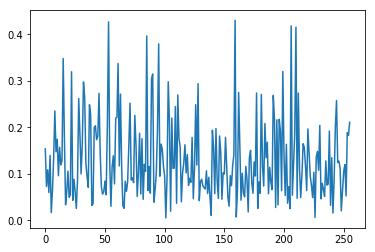

In [25]:
import pylab as plt
from torchvision.transforms import ToTensor
to_tensor = ToTensor()
dog = to_tensor(Image.open('/home/liam/Desktop/dog.jpg')).to(device)
with torch.no_grad():
    targ = model((dog - mean) / std)
plt.plot(targ.cpu().numpy()[0])

weight -0.00018713016470428556
grad tensor(0.0065, device='cuda:0')
cost -0.08153312653303146


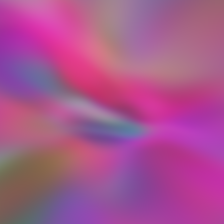

weight -0.0013931577559560537
grad tensor(0.0067, device='cuda:0')
cost -0.8743475675582886


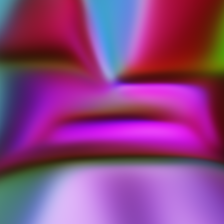

weight -0.0019522802904248238
grad tensor(0.0051, device='cuda:0')
cost -1.1840810775756836


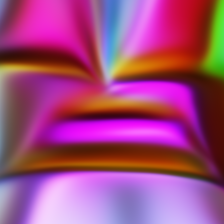

weight -0.0019389359513297677
grad tensor(0.0063, device='cuda:0')
cost -1.3498564958572388


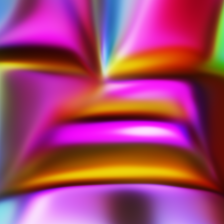

weight -0.0019172198371961713
grad tensor(0.0095, device='cuda:0')
cost -1.5099197626113892


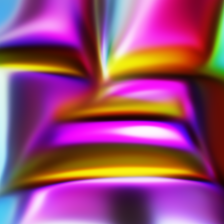

weight -0.0019970149733126163
grad tensor(0.0092, device='cuda:0')
cost -1.5902719497680664


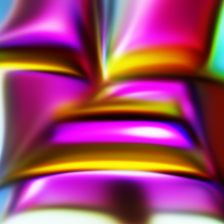

weight -0.0017431415617465973
grad tensor(0.0074, device='cuda:0')
cost -1.7332085371017456


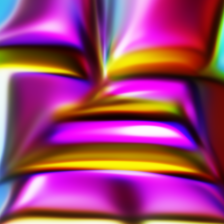

weight -0.0017433369066566229
grad tensor(0.0106, device='cuda:0')
cost -1.8356174230575562


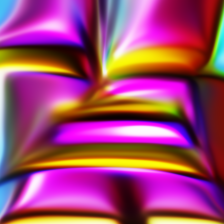

weight -0.0018268375424668193
grad tensor(0.0081, device='cuda:0')
cost -1.9109928607940674


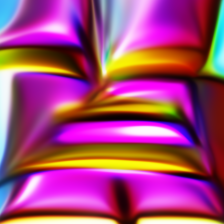

KeyboardInterrupt: 

In [73]:
def imgnet_objective(output):
    r = model((output - mean) / std)
#     return torch.mean((r - targ) ** 2)
    return -r[:, 18].mean()

widths = [36] * 10
viz = Net(widths).to(device)
cppn_f = lambda: viz(xy)
opt = optim.Adam(viz.parameters(), lr=0.002)
# opt = optim.SGD(viz.parameters(), lr=0.01, momentum=0.9)
render_vis(viz, imgnet_objective, cppn_f, opt, iters=30*50, log_interval=50)

In [74]:
xy_big = get_xy([1080, 1920])

In [75]:
xy_big.shape

torch.Size([1, 2, 1080, 1920])

In [82]:
import gc
gc.collect()

3006

In [83]:
with torch.no_grad(): big_im = viz(xy_big.to(device)).to('cpu')

In [84]:
plt.imsave('cool.png', big_im[0].permute(1, 2, 0).numpy())

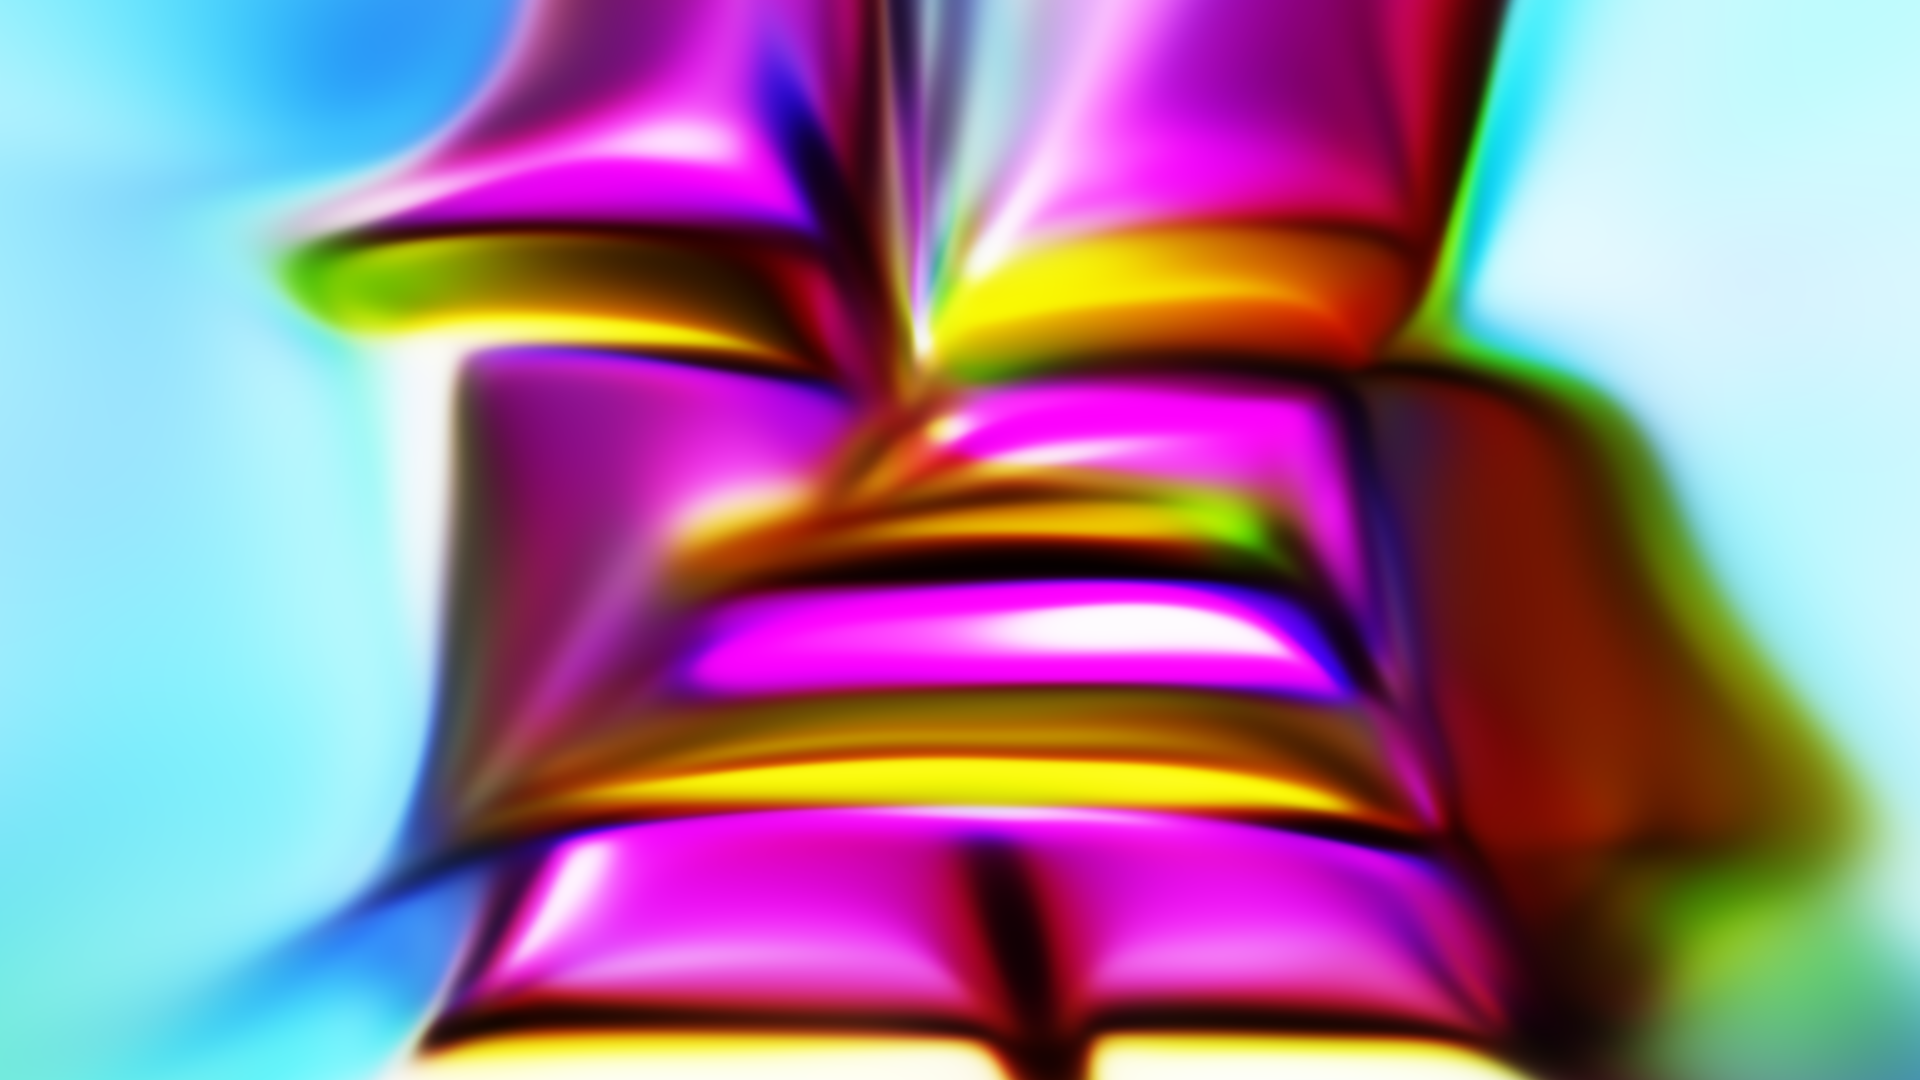

In [85]:
display_tch_im(big_im)